# Data mining on churn dataset

In the previous section, we built various model to solve our classification problem using a training dataset and we compared them on a validation dataset in order to choose the most _robust_ among them. 

In this section we want to: 
* evaluate this model on a test dataset in order to have an unbiased measure of its performance and 
* apply the model on a score dataset in order to predict the unknown target classes

We will also set a new threshold based on the costs associated to the different errors in the confusion matrix and use it to make the predictions on the score dataset. 

First, let's take ourselves after the assessment phase:

In [36]:
# Import clean data
churn <- read.table('datasets/churn_working_clean.csv', header=T, sep = ',')
churn = subset(churn, select = -1)

In [37]:
# Partitioning
set.seed(99)
splitSample <- sample(3, size=nrow(churn), prob=c(0.6,0.2,0.2), replace = TRUE)
churn_train = data.frame(churn[splitSample==1,])
churn_valid = data.frame(churn[splitSample==2,])
churn_test  = data.frame(churn[splitSample==3,])

In [61]:
# Training
library("randomForest")
model.rforest = randomForest(Churn ~ ., data=churn_train, ntree=500, nodesize=3)

## Evaluation

Here, we want to evaluate the performance of the final model, the one that will be used to predict new values. Here the threshold is set or is determined as a parameter in a minimization problem. 

### Confusion matrix

Let's consider the case of threshold set to the default value of .5:

In [39]:
# Probabilities
prob <- predict(model.rforest, newdata=churn_test, type="prob")
# Predictions
predictions=as.integer(prob[,2]>0.5)
#True 
true=as.integer(churn_test$'Churn')-1

With [caret](https://cran.r-project.org/web/packages/caret/index.html) library we can visualize the confusion matrix and the performance measure derived:

In [62]:
#install.packages("caret")
#install.packages("e1071")
library("caret")
confusionMatrix(predictions,true)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 376  29
         1   6  45
                                         
               Accuracy : 0.9232         
                 95% CI : (0.8949, 0.946)
    No Information Rate : 0.8377         
    P-Value [Acc > NIR] : 4.871e-08      
                                         
                  Kappa : 0.6773         
 Mcnemar's Test P-Value : 0.0002003      
                                         
            Sensitivity : 0.9843         
            Specificity : 0.6081         
         Pos Pred Value : 0.9284         
         Neg Pred Value : 0.8824         
             Prevalence : 0.8377         
         Detection Rate : 0.8246         
   Detection Prevalence : 0.8882         
      Balanced Accuracy : 0.7962         
                                         
       'Positive' Class : 0              
                                         

In particular we observe the following values (note that in the confusion matrix the positive event is y=0):
* Accuracy: 0.9232 
* Precision (Pos Pred Value): 0.9284
* Recall (Sensitivity): 0.9843
* Specificity: 0.6081

We note that accuracy (#true/#total), precision (#true positives/#predicted positives) and recall (#true positives/#actual positives) are adequate considering the small quantity of data. Recall is higher than precision, which can be useful in a scenario in which we want to avoid false negatives more than false positives. On the contrary specifity (#true negatives/#actual negatives) is pretty low.

### Cost matrix

In a classification problem it's possible to associate a specific profit or cost to each event of or incorrect classification.

| predicted >>| yes | no  |
|-------------|-----|-----|
| yes         | $a$ | $c$ |
| no          | $b$ | $d$ |


We can then define synthetic performance measure which take account of this matrix, as the Individual Expected Profit for the events:
* $\text{EP}(\hat{y}=1) = a \hat{p}_1 + b \hat{p}_0$
* $\text{EP}(\hat{y}=0) = c \hat{p}_1 + d \hat{p}_0$

and the Total Expected Profit (TEP):
* $\text{TEP}$ = $a$ TP + $b$ FN + $c$ FP + $d$ TN

Here we define the following cost matrix and we'll try to maximize total expected profit:

| predicted >>| yes | no |
|-------------|-----|----|
| yes         | -10 | 10 |
| no          | 3   | 0  |


As we've done for the assessment measures, first we create the objects containing the measures using [ROCR](https://cran.r-project.org/web/packages/ROCR/index.html) package:

In [52]:
#install.packages("ROCR")
library("ROCR")

In [55]:
pred <- prediction(prob[,2], true)
cost <- performance(pred, measure='cost',
                      cost.tp=-10,cost.fn=10,cost.fp=3,cost.tn=0)
cost_df <- data.frame(cutoff=unlist(cost@x.values),explicit_cost=unlist(cost@y.values))

Then we visualize them in a graph containing the expected cost vs threshold:

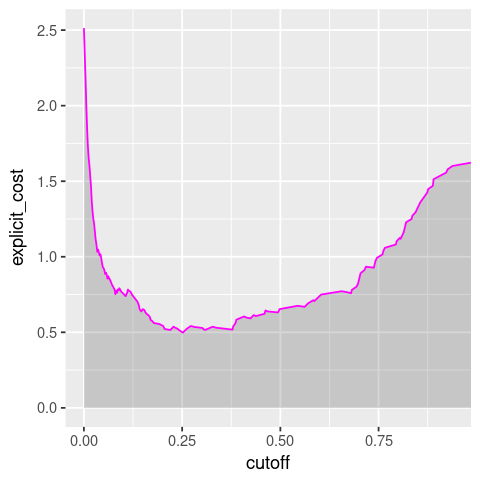

In [58]:
options(repr.plot.width=4, repr.plot.height=4)
ggplot(data=cost_df, aes(x=cutoff, ymin=explicit_cost, ymax=0)) +
    geom_ribbon(alpha=0.2) +
    geom_line(aes(y=explicit_cost), color = 'magenta')

We take the cutoff point that minimizes the cost:

In [59]:
explicit_cost <- data.frame(unlist(cost@y.values))
argmin <- which.min(apply(explicit_cost,MARGIN=1,min))
cost_df[argmin,]

,cutoff,explicit_cost
1141,0.252,0.497807


The threshold we obtained is 0.252, which means that Churn will be classified as yes (y=0) if the probability is higher than 1 minus this value.

In [63]:
threshold = cost_df[argmin,'cutoff']

## Score

In this final part we apply the model with the default threshold and with the one that maximies the expected profit for the provided cost matrix.

First we import the score dataset, previously processed in order to be clean and with the right features:

In [64]:
churn_score <- read.table('datasets/churn_score_clean.csv', header=T, sep = ',')
churn_score = subset(churn_score, select = -1 )

In [65]:
str(churn_score)

'data.frame':	9 obs. of  6 variables:
 $ Int.l.Plan    : Factor w/ 1 level "False": 1 1 1 1 1 1 1 1 1
 $ VMail.Plan    : Factor w/ 2 levels "False","True": 1 1 2 1 1 1 1 1 2
 $ Day.Mins      : num  131 185 176 132 200 ...
 $ Intl.Mins     : num  15.6 14.1 8.6 10.7 11.3 12.2 11.9 6.9 11.8
 $ Intl.Calls    : int  3 3 3 3 7 2 6 5 5
 $ CustServ.Calls: int  3 3 2 1 1 1 1 2 1


In [66]:
str(churn_train)

'data.frame':	1404 obs. of  7 variables:
 $ Int.l.Plan    : Factor w/ 2 levels "False","True": 1 1 1 1 1 2 1 1 1 1 ...
 $ VMail.Plan    : Factor w/ 2 levels "False","True": 1 1 1 1 2 1 1 1 2 1 ...
 $ Day.Mins      : num  131 185 200 287 172 ...
 $ Intl.Mins     : num  15.6 14.1 11.3 6.9 11.8 13.8 9.7 8.9 10.3 7.2 ...
 $ Intl.Calls    : int  3 3 7 5 5 2 2 5 2 7 ...
 $ CustServ.Calls: int  3 3 1 2 1 1 3 1 0 1 ...
 $ Churn         : Factor w/ 2 levels "False","True": 1 1 1 1 1 2 1 2 1 1 ...


As the score dataset contains a reduced number of examples to be classified, the features may not have all the values present in the training phase. To solve this problem, we manually set the type of the wrong features: 

In [67]:
levels(churn_score$Int.l.Plan) <- levels(churn_train$Int.l.Plan)

Now we apply the model to get the class probabilities for the examples: 

In [68]:
prob <- predict(model.rforest, newdata=churn_score, type="prob")
prob

,False,True
1,0.924,0.076
2,1.000,0.000
3,0.986,0.014
4,0.980,0.020
5,0.998,0.002
6,0.996,0.004
7,0.994,0.006
8,0.444,0.556
9,0.996,0.004


And we classify them considering the different thresholds:

In [70]:
prob[,2] > 0.5

1     2     3     4     5     6     7     8     9 
FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE FALSE

In [71]:
prob[,2] > 1-threshold

1     2     3     4     5     6     7     8     9 
FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE